In [19]:
# Acessando a API do Twitter
# Documentação da API: http://docs.tweepy.org/en/v3.5.0/
# Rodar no cmd: jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000

import tweepy
import json
import csv
import pandas

# Carrega as credenciais da API do Twitter
# Nesse caso, as credenciais estão em um JSON salvo no mesmo diretório, que vai ser puxado pelo código
with open('credenciais_twitter.json') as cred_data:
    info = json.load(cred_data)
    consumer_key = info['consumer_key']
    consumer_secret = info['consumer_secret']
    access_token = info['access_token']
    access_token_secret = info['access_token_secret']

# Autorização e inicialização da tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

meus_amigos = ["caiqalencar", "galhardothami", "letoangio", "guivianan", "flaranjeira96", "gicamiotto", "himariana"]
planilha = []

for usuario in meus_amigos:
    consulta_api = api.get_user(usuario)._json
    usuario = consulta_api["screen_name"]
    nome = consulta_api["name"]
    seguidores = consulta_api["followers_count"]
    descricao = consulta_api["description"]
    tweets = consulta_api["statuses_count"]
    print(f"Usuário: {usuario}")
    print(f"Nome: {nome}")
    print(f"Seguidores: {seguidores}")
    print(f"Descrição: {descricao}")
    print(f"Tweets: {tweets}")
    print()
    
    dicionario = {"Usuário": usuario, "Seguidores": seguidores, "Quantidade de tweets": tweets}
    planilha.append(dicionario)
    
# Exibição dos dados de forma mais bonita usando df do pandas
df = pandas.DataFrame(planilha)
df.sort_values(by = "Quantidade de tweets", ascending = False)

# Linha gera arquivo CSV com base no dataframe do pandas
# df.to_csv("twitter_usuarios.csv", sep=";", encoding='utf-8')

Usuário: caiqalencar
Nome: Caíque Alencar
Seguidores: 188
Descrição: Jornalista de dados. Formado pela @metodista. Ex-foca do @Estadao. Passagens pelo @portalR7 e @reporterdiario. Tenho interesse por #ddj e sou #teampython.
Tweets: 7788

Usuário: galhardothami
Nome: Titinininha ❤
Seguidores: 82
Descrição: Jornalista, 23.
Tweets: 3664

Usuário: LetoAngio
Nome: math
Seguidores: 377
Descrição: Jornalista, 22. Look for the light, believe in the fireflies.
Tweets: 40805

Usuário: GuiVianaN
Nome: Guilherme da C-137
Seguidores: 138
Descrição: Driving to eat a Carvel cake
Tweets: 14623

Usuário: flaranjeira96
Nome: Boi do Piauí
Seguidores: 144
Descrição: Aproveite os desvios da jornada. São neles que você encontrará aquilo que é mais importante
Tweets: 5635

Usuário: gicamiotto
Nome: Mia Colucci
Seguidores: 443
Descrição: 21 anos, sulsancaetanense, jornalista, bailarina.
Tweets: 47360

Usuário: himariana
Nome: pinscher com raiva
Seguidores: 258
Descrição: 
Tweets: 72468



,Quantidade de tweets,Seguidores,Usuário
6,72468,258,himariana
5,47360,443,gicamiotto
2,40805,377,LetoAngio
3,14623,138,GuiVianaN
0,7788,188,caiqalencar
4,5635,144,flaranjeira96
1,3664,82,galhardothami


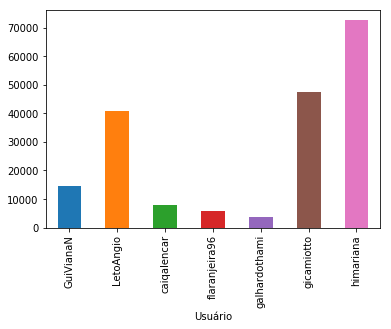

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

grafico_seguidores = df.groupby("Usuário")["Seguidores"].mean()
grafico_seguidores.plot.bar()

grafico_tweets = df.groupby("Usuário")["Quantidade de tweets"].mean()
grafico_tweets.plot.bar()

# Não precisa usar o comando get_figure() pra não imprimir o gráfico duas vezes
# agrupamento.plot.bar().get_figure()

In [ ]:
# Faz raspagem de tweets sem usar o tweepy
# É mais devagar, mas ultrapassa 3200 tweets
# Também é possível selecionar as datas

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException, StaleElementReferenceException
from time import sleep
import json
import datetime

# edit these three variables
user = 'galhardothami'
start = datetime.datetime(2015, 4, 1)  # year, month, day
end = datetime.datetime(2019, 2, 25)  # year, month, day

# only edit these if you're having problems
delay = 1  # time to wait on each page load before reading the page
driver = webdriver.Chrome()  # options are Chrome() Firefox() Safari()

# don't mess with this stuff
twitter_ids_filename = 'all_ids.json'
days = (end - start).days + 1
id_selector = '.time a.tweet-timestamp'
tweet_selector = 'li.js-stream-item'
user = user.lower()
ids = []

def format_day(date):
    day = '0' + str(date.day) if len(str(date.day)) == 1 else str(date.day)
    month = '0' + str(date.month) if len(str(date.month)) == 1 else str(date.month)
    year = str(date.year)
    return '-'.join([year, month, day])

def form_url(since, until):
    p1 = 'https://twitter.com/search?f=tweets&vertical=default&q=from%3A'
    p2 =  user + '%20since%3A' + since + '%20until%3A' + until + 'include%3Aretweets&src=typd'
    return p1 + p2

def increment_day(date, i):
    return date + datetime.timedelta(days=i)

for day in range(days):
    d1 = format_day(increment_day(start, 0))
    d2 = format_day(increment_day(start, 1))
    url = form_url(d1, d2)
    print(url)
    print(d1)
    driver.get(url)
    sleep(delay)

    try:
        found_tweets = driver.find_elements_by_css_selector(tweet_selector)
        increment = 10

        while len(found_tweets) >= increment:
            print('scrolling down to load more tweets')
            driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
            sleep(delay)
            found_tweets = driver.find_elements_by_css_selector(tweet_selector)
            increment += 10

        print('{} tweets found, {} total'.format(len(found_tweets), len(ids)))

        for tweet in found_tweets:
            try:
                id = tweet.find_element_by_css_selector(id_selector).get_attribute('href').split('/')[-1]
                ids.append(id)
            except StaleElementReferenceException as e:
                print('lost element reference', tweet)

    except NoSuchElementException:
        print('no tweets on this day')

    start = increment_day(start, 1)

try:
    with open(twitter_ids_filename) as f:
        all_ids = ids + json.load(f)
        data_to_write = list(set(all_ids))
        print('tweets found on this scrape: ', len(ids))
        print('total tweet count: ', len(data_to_write))

except FileNotFoundError:
    with open(twitter_ids_filename, 'w') as f:
        all_ids = ids
        data_to_write = list(set(all_ids))
        print('tweets found on this scrape: ', len(ids))
        print('total tweet count: ', len(data_to_write))

with open(twitter_ids_filename, 'w') as outfile:
    json.dump(data_to_write, outfile)

print('all done here')
driver.close()